<a href="TAIL"><img src="https://i.imgur.com/GRTE0OG.png" width="150" title="Tail Logo" /></a>

# <font color ="#00b8ff"> Detecção de Tumores Cerebrais </font>

##  <font color ="#00b8ff"> 1 - Importação dos dados </font>
É necessário importar as imagens do cérebro em que os tumores estão presentes. O conjunto de dados pode ser dividido em conjuntos de treinamento, validação e teste.

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
import keras
from keras import preprocessing
from PIL import Image
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
import shutil


In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from io import BytesIO
import requests
import zipfile

url = "https://github.com/Franky03/Images/blob/main/archive%20(1).zip?raw=true"

response = requests.get(url)
print(response)
imgs_zip = BytesIO(response.content)

with zipfile.ZipFile(imgs_zip) as imgs:
  imgs.extractall('./')


<Response [200]>


In [ ]:
with zipfile.ZipFile('./Brain Tumor.zip') as imgs:
  imgs.extractall('./')

df = pd.read_csv("Brain Tumor.csv")

In [ ]:
df_class = df[["Image", "Class"]]
df_class

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0
...,...,...
3757,Image3758,0
3758,Image3759,0
3759,Image3760,0
3760,Image3761,0


In [ ]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3762 non-null   object
 1   Class   3762 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.9+ KB


In [ ]:
origin_path = "/content/Brain Tumor"
yes_path = "/content/brain_tumor_dataset/yes"
no_path = "/content/brain_tumor_dataset/no"

count = 0

for i in range(df_class.shape[0]):
  image = df_class["Image"][i]
  class_ = df_class["Class"][i]
  image_path = f"{origin_path}/{image}.jpg"

  if class_ == 1:
    destiny = f"{yes_path}/{image}_t.jpg" # t is just to distinguish from the originals
  elif class_ == 0:
    destiny = f"{no_path}/{image}_t.jpg"
  else:
    print("No class")
    continue

  shutil.copyfile(image_path, destiny)

  count += 1

print(f"Finished with {count} images.")


Finished with 3762 images.


##  <font color ="#00b8ff"> 2 - Pré-processamento de dados </font>
O pré-processamento pode incluir o redimensionamento das imagens, normalização, filtragem e eliminação de ruído para preparar as imagens para o treinamento do modelo.



### Extraindo os dados manualmente

In [ ]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0 #Normalização
  return image

In [ ]:
def load_dataset(folder, label):
  images = []
  for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size= (200, 200))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    images.append(preprocess_image(img_array))

  labels = [label] * len(images)
  return tf.data.Dataset.from_tensor_slices((images, labels))


In [ ]:
true_dataset = load_dataset("./brain_tumor_dataset/yes", 1)
false_dataset = load_dataset("./brain_tumor_dataset/no", 0)

train_dataset = true_dataset.concatenate(false_dataset)
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset)).batch(batch_size=32)

for image_batch, label_batch in train_dataset.take(1):
  print("x_train shape:", image_batch.shape)
  print("y_train shape:", label_batch.shape)

x_train shape: (32, 200, 200, 3)
y_train shape: (32,)


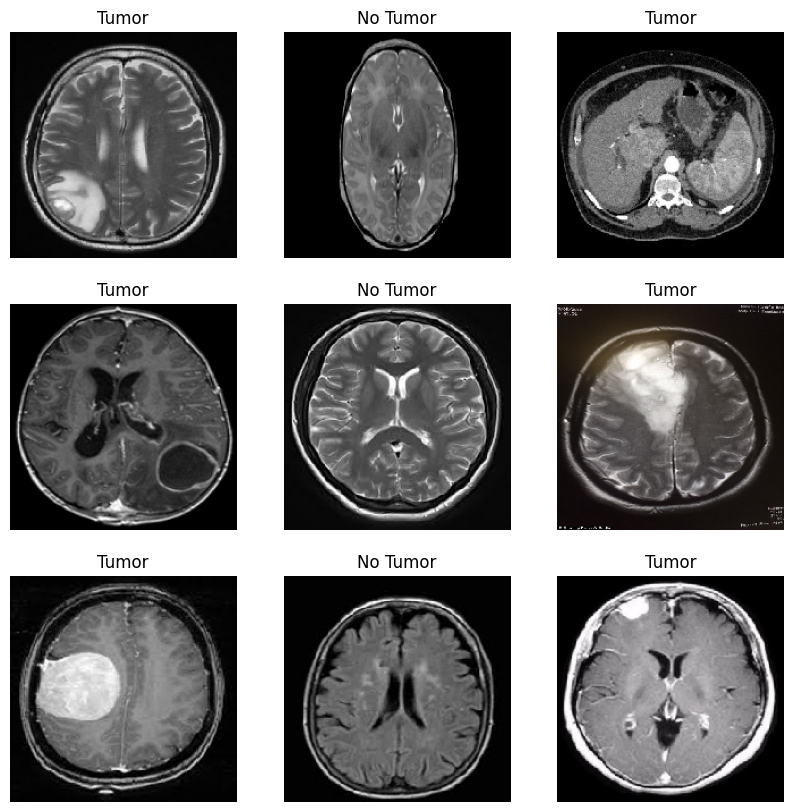

In [ ]:
class_names = ["No Tumor", "Tumor"]

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(9):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image_batch[n])
    plt.title(class_names[int(label_batch[n])])
    plt.axis('off')
  plt.show()

for image_batch, label_batch in train_dataset.take(1):
    show_batch(image_batch, label_batch)

### Maneira mais fácil

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (200, 200)
BATCH_SIZE = 32
directory = "./brain_tumor_dataset/"

train_dataset = tf.keras.utils.image_dataset_from_directory(
  directory,
  labels='inferred',
  label_mode='binary',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  interpolation='nearest',
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  directory,
  labels='inferred',
  label_mode='binary',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  interpolation='nearest',
  batch_size=BATCH_SIZE)

Found 4015 files belonging to 2 classes.
Using 3212 files for training.
Found 4015 files belonging to 2 classes.
Using 803 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['no', 'yes']

In [ ]:
train_dataset.take(1).element_spec

(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

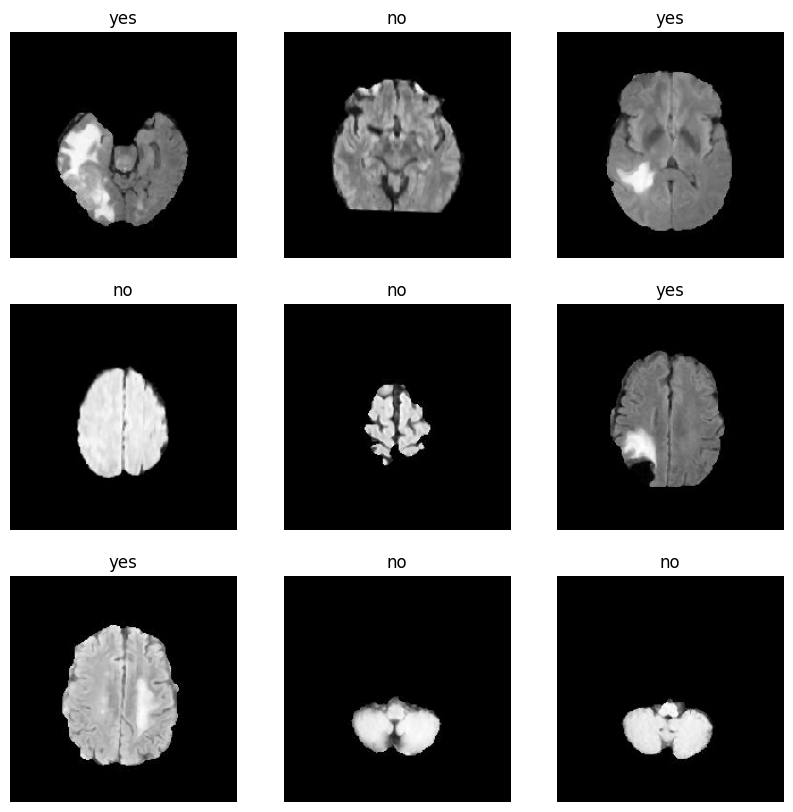

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.title(class_names[int(labels[i])])
        plt.axis("off")

##  <font color ="#00b8ff"> 3 - Data Augmentation </font>

Como o conjunto de dados pode ser pequeno, a técnica de aumento de dados pode ser usada para gerar imagens adicionais de treinamento, aumentando assim a variedade dos dados de treinamento. Algumas técnicas de aumento de dados que podem ser usadas incluem rotação, translação, zoom, espelhamento, mudança de brilho e contraste.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
  '''
    Cria um modelo Sequencial composto por 2 layers

    Retorna um tf.keras.Sequential
    '''

  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip("horizontal"))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation


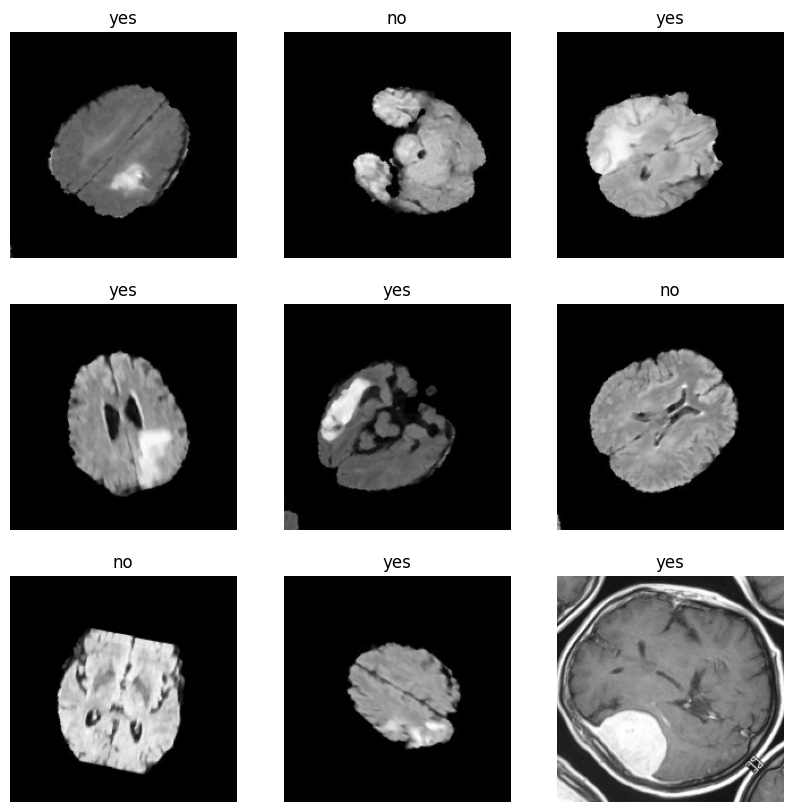

In [ ]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(augmented_image[0] / 255, cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


Lembrar de:

Ao chamar image_data_set_from_directory(), especifique os subconjuntos de treino / validação e combine as sementes para evitar sobreposição.


Use prefetch() para evitar gargalos de memória ao ler do disco.

Dê mais para o seu modelo aprender com simples aumentos de dados, como rotação e inversão.

Ao usar um modelo pré-treinado, é melhor reutilizar os pesos nos quais foi treinado.

### <font color ="#00b8ff"> 4 - Criação do modelo </font>
Para a criação do modelo de visão computacional, pode-se utilizar uma arquitetura de rede neural convolucional (CNN). As CNNs são conhecidas por sua eficácia em tarefas de visão computacional, como detecção de objetos e classificação de imagens.

#### InceptionV3

In [ ]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Dropout, Flatten, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Concatenate, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import layers


# pretrain_model = InceptionV3(
#       include_top=False,
#       weights='imagenet',
#       input_shape=(200,200,3)
#   )

# pretrain_model.trainable = True

# for layer in pretrain_model.layers[:-10]:
#   layer.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
def create_model(input_shape, data_augmentation=data_augmenter()):

    base_model = InceptionV3(input_shape=input_shape,
                             include_top=False,
                            weights='imagenet')

    # Congelar o modelo base para torná-lo não treinável
    base_model.trainable = False
    # Criar uma camada de input (mesmo tamanho do input da InceptionV3)
    inputs = tf.keras.Input(shape=input_shape)
    # Aplicar aumento de dados aos inputs
    x = data_augmentation(inputs)
    # Pré-processamento de dados usando os mesmos pesos que o modelo foi treinado
    x = preprocess_input(x)
    # Definir o treinamento como falso para evitar o acompanhamento de estatísticas na camada de batch norm
    x = base_model(x, training=False)
    # Adicionar as novas camadas de classificação binária
    # Usar média global de pooling para resumir a informação em cada canal
    x = tfl.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    # Incluir Dropout com probabilidade de 0,2 para evitar overfitting
    x = tfl.Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)  # Adicionando uma camada oculta
    x = tfl.Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)  # Adicionando outra camada oculta
    x = tfl.Dropout(0.2)(x)
    # Usar uma camada de previsão com um neurônio (como um classificador binário só precisa de um)
    outputs = tfl.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    return model



In [ ]:
inception_model = create_model((200, 200, 3))

In [ ]:
inception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0     

## <font color ="#00b8ff"> 5 - Treinamento do modelo </font>

O modelo pode ser treinado usando o conjunto de dados de treinamento e validação usando uma função de perda adequada para otimizar o modelo. É importante monitorar a precisão do modelo durante o treinamento para garantir que ele esteja melhorando.

In [ ]:
base_learning_rate = 1e-5
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 16
history = inception_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/16
101/101 [==============================] - 17s 93ms/step - loss: 0.8378 - accuracy: 0.5174 - val_loss: 0.6573 - val_accuracy: 0.5990
Epoch 2/16
101/101 [==============================] - 8s 73ms/step - loss: 0.7096 - accuracy: 0.5859 - val_loss: 0.5828 - val_accuracy: 0.7036
Epoch 3/16
101/101 [==============================] - 9s 81ms/step - loss: 0.6460 - accuracy: 0.6364 - val_loss: 0.5440 - val_accuracy: 0.7484
Epoch 4/16
101/101 [==============================] - 9s 83ms/step - loss: 0.6218 - accuracy: 0.6715 - val_loss: 0.5195 - val_accuracy: 0.7634
Epoch 5/16
101/101 [==============================] - 8s 73ms/step - loss: 0.5737 - accuracy: 0.7154 - val_loss: 0.4960 - val_accuracy: 0.7796
Epoch 6/16
101/101 [==============================] - 9s 81ms/step - loss: 0.5553 - accuracy: 0.7257 - val_loss: 0.4750 - val_accuracy: 0.7958
Epoch 7/16
101/101 [==============================] - 9s 83ms/step - loss: 0.5301 - accuracy: 0.7441 - val_loss: 0.4612 - val_accuracy: 0.800

In [ ]:
train_result = inception_model.evaluate(train_dataset)
val_result = inception_model.evaluate(validation_dataset)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

26/26 [==============================] - 2s 51ms/step - loss: 0.3732 - accuracy: 0.8418


,Train,Val
Loss,0.351751,0.373224
Acc,0.857410,0.841843


##  <font color ="#00b8ff"> 6 - Avaliação do modelo </font>
Após o treinamento, o modelo pode ser avaliado usando o conjunto de dados de teste para verificar a eficácia da detecção de tumores. É importante avaliar o desempenho do modelo usando métricas como precisão, recall e F1-score.

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

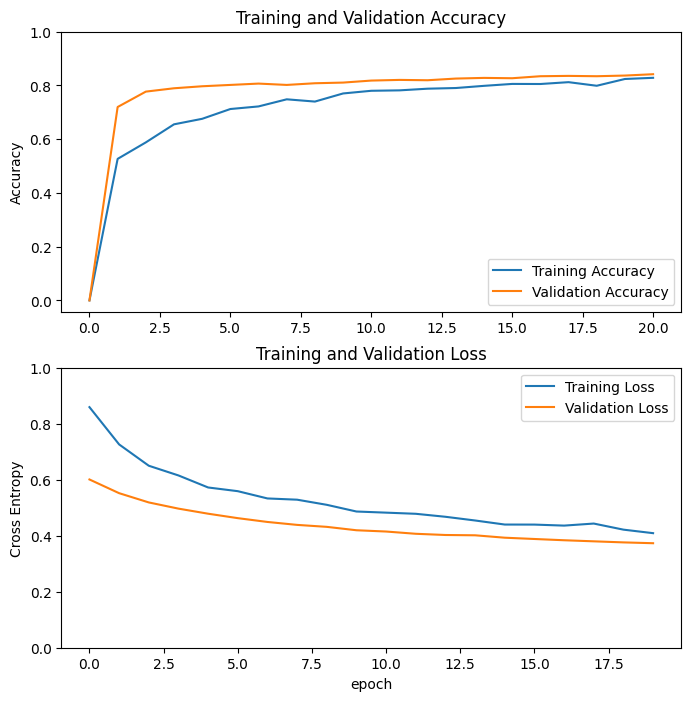

In [ ]:
plot_learning_curve(history)

In [ ]:
with zipfile.ZipFile('./Brain Tumor.zip') as imgs:
  imgs.extractall('./')

In [ ]:
def load_random_images(folder_path, num_images, target_size):
    # obter a lista de arquivos na pasta
    files = os.listdir(folder_path)
    # selecionar aleatoriamente o número desejado de imagens
    selected_files = np.random.choice(files, num_images, replace=False)

    images = []
    for file in selected_files:
        print(file)
        # carregar a imagem e redimensionar para o tamanho desejado
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder_path, file), target_size=target_size)
        # converter a imagem em um array numpy e normalizar
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x/255.0
        images.append(x)

    return np.vstack(images)

In [ ]:
images = load_random_images('./brain_tumor_dataset/yes', 9, (200, 200))
predictions = inception_model.predict(images)


Image2511_t.jpg
Image2963_t.jpg
Image3340_t.jpg
Y246.JPG
Image2178_t.jpg
Image2962_t.jpg
Image3517_t.jpg
Image2376_t.jpg
Image177_t.jpg
1/1 [==============================] - 0s 33ms/step


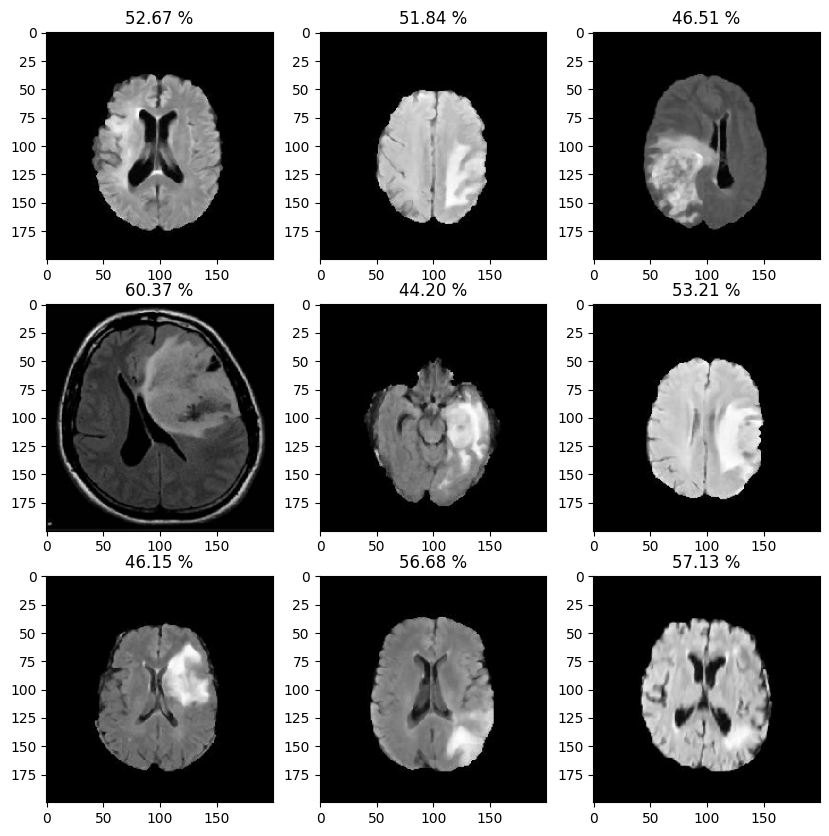

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"{(predictions[i][0] * 100):.2f} %")

plt.show()

In [ ]:
images = load_random_images('./brain_tumor_dataset/no', 9, (200, 200))
predictions = inception_model.predict(images)

Image3605_t.jpg
Image2165_t.jpg
Image470_t.jpg
Image3262_t.jpg
Image669_t.jpg
Image1851_t.jpg
Image2381_t.jpg
Image125_t.jpg
Image933_t.jpg
1/1 [==============================] - 0s 71ms/step


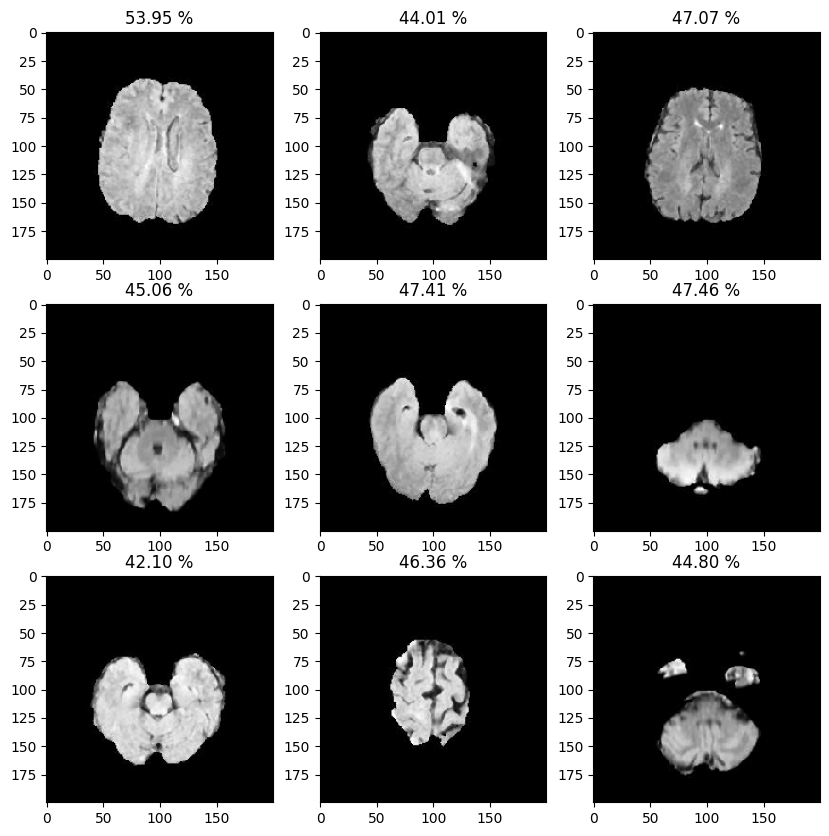

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"{(predictions[i][0] * 100):.2f} %")

plt.show()

##  <font color ="#00b8ff"> 7 - Ajuste do modelo </font>
Se o desempenho do modelo não for satisfatório, o modelo pode ser ajustado com ajustes em sua arquitetura, hiperparâmetros ou técnicas de pré-processamento.

 Fine-tuning the Model


In [ ]:
base_model = inception_model.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function= tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate= base_learning_rate)
metrics= ['accuracy']

inception_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)



Number of layers in the base model:  311


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = inception_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
101/101 [==============================] - 42s 146ms/step - loss: 0.3472 - accuracy: 0.8515 - val_loss: 0.2504 - val_accuracy: 0.8979
Epoch 21/30
101/101 [==============================] - 15s 144ms/step - loss: 0.2429 - accuracy: 0.9063 - val_loss: 0.1747 - val_accuracy: 0.9290
Epoch 22/30
101/101 [==============================] - 14s 132ms/step - loss: 0.1884 - accuracy: 0.9306 - val_loss: 0.1969 - val_accuracy: 0.9240
Epoch 23/30
101/101 [==============================] - 14s 134ms/step - loss: 0.1690 - accuracy: 0.9384 - val_loss: 0.1454 - val_accuracy: 0.9377
Epoch 24/30
101/101 [==============================] - 14s 139ms/step - loss: 0.1402 - accuracy: 0.9511 - val_loss: 0.1474 - val_accuracy: 0.9390
Epoch 25/30
101/101 [==============================] - 14s 132ms/step - loss: 0.1130 - accuracy: 0.9623 - val_loss: 0.1601 - val_accuracy: 0.9340
Epoch 26/30
101/101 [==============================] - 14s 132ms/step - loss: 0.1133 - accuracy: 0.9558 - val_loss: 0.1472 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

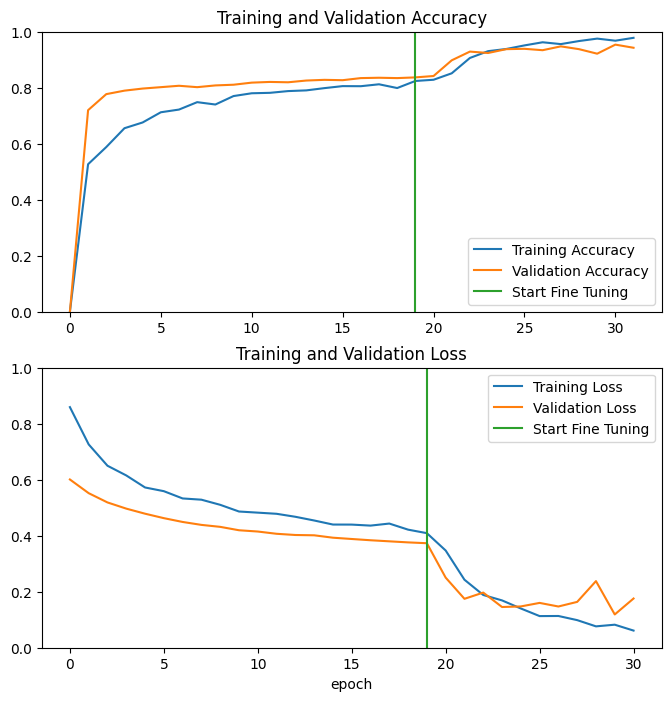

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
images = load_random_images('./Brain Tumor/', 9, (200, 200))
predictions = inception_model.predict(images)

Image3426.jpg
Image398.jpg
Image2252.jpg
Image897.jpg
Image1762.jpg
Image567.jpg
Image3205.jpg
Image3277.jpg
Image1950.jpg
1/1 [==============================] - 2s 2s/step


In [ ]:
print(predictions)

[[0.07079805]
 [0.01184674]
 [0.00781733]
 [0.12341017]
 [0.00525727]
 [0.00825175]
 [0.0113863 ]
 [0.0149014 ]
 [0.01487859]]


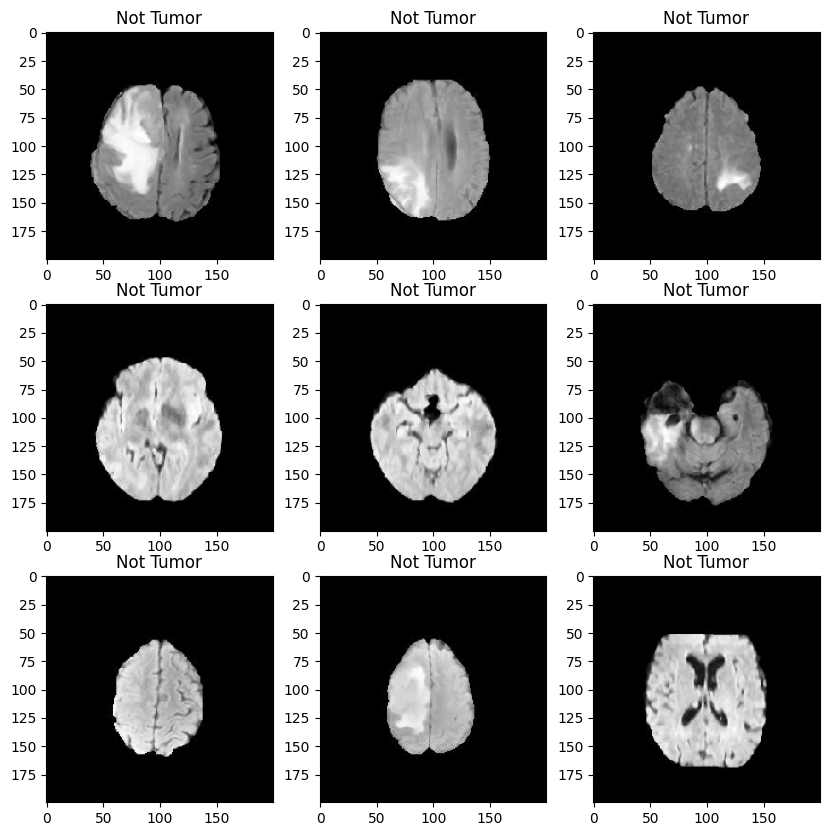

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    classe = "Tumor" if predictions[i][0] >0.5 else "Not Tumor"
    ax.set_title(classe)

plt.show()

In [ ]:
def predict_image(model, image_path):

    # Carrega a imagem como um tensor e redimensiona para o tamanho esperado pelo modelo
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

    # Faz a predição usando o modelo e a imagem carregada
    prediction = model.predict(img_array)[0][0]

    # Mostra a imagem e a predição como título
    plt.imshow(img)
    plt.title(f"Predição: {prediction*100:.2f}%")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 28ms/step


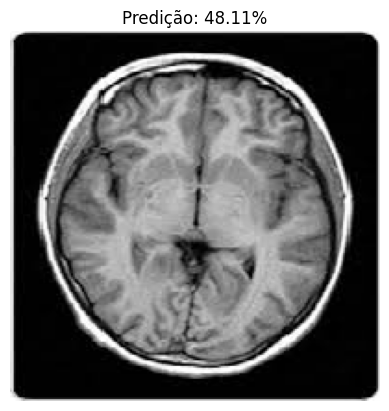

In [ ]:
predict_image(inception_model, "/content/brain_tumor_dataset/no/20 no.jpg")

1/1 [==============================] - 0s 54ms/step


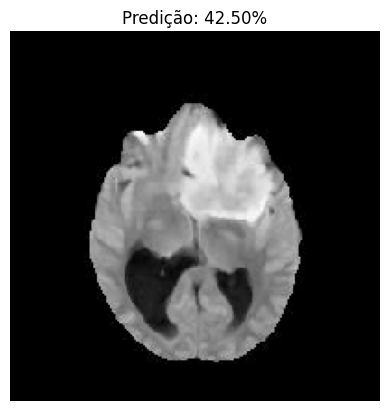

In [ ]:
predict_image(inception_model, "/content/brain_tumor_dataset/yes/Image3010_t.jpg")